Current machine learning techniques are data-hungry and brittle—they can only make sense of patterns they've seen before. Using current methods, an algorithm can gain new skills by exposure to large amounts of data, but cognitive abilities that could broadly generalize to many tasks remain elusive. This makes it very challenging to create systems that can handle the variability and unpredictability of the real world, such as domestic robots or self-driving cars.

However, alternative approaches, like inductive programming, offer the potential for more human-like abstraction and reasoning. The Abstraction and Reasoning Corpus (ARC) provides a benchmark to measure AI skill-acquisition on unknown tasks, with the constraint that only a handful of demonstrations are shown to learn a complex task. It provides a glimpse of a future where AI could quickly learn to solve new problems on its own. The Kaggle Abstraction and Reasoning Challenge invites you to try your hand at bringing this future into the present!



In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch
from tensorflow import keras # keras 2.0.6 tf 1.X   tf 2.X from tensorflow import keras
import time

In [2]:
# 定义路径
train_path = './input/training'
test_path = './input/test'
SIZE = 10

In [5]:
train_dir = os.listdir(train_path)
test_dir = os.listdir(test_path)

# 将训练数据加载为json格式的task1和task2
with open(os.path.join(train_path, train_dir[0])) as f:
    task1 = json.load(f)
    
with open(os.path.join(train_path, train_dir[1])) as f:
    task2 = json.load(f)

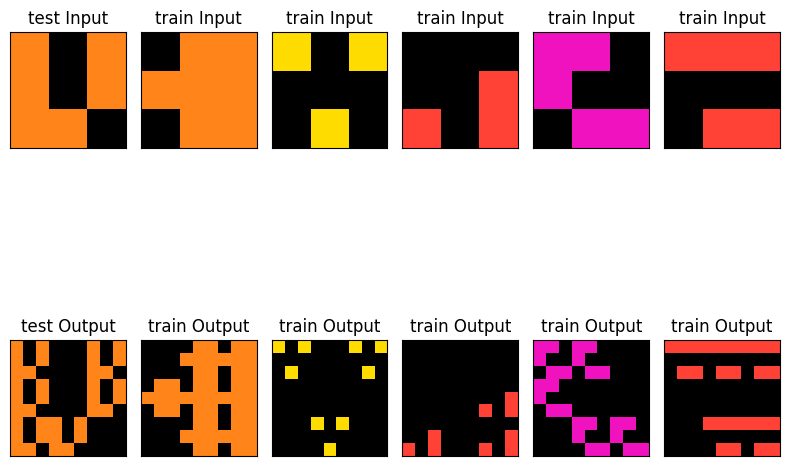

In [6]:
# 将相应的task进行可视化
def plot_task(task):
    index = 0
    # ten kinds of colors
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    task_num = len(task['train']) + len(task['test'])
    fig, ax = plt.subplots(2, task_num, figsize=(8,8))
    for k, v in task.items():
        for j in v:
            ax[0, index].imshow(j['input'], cmap=cmap, norm=norm)
            ax[0, index].set_xticklabels([])
            ax[0, index].set_yticklabels([])
            ax[0, index].tick_params(length=0)
            ax[0, index].set_title(k + ' Input')
            ax[1, index].imshow(j['output'], cmap=cmap, norm=norm)
            ax[1, index].set_xticklabels([])
            ax[1, index].set_yticklabels([])
            ax[1, index].tick_params(length=0)
            ax[1, index].set_title(k + ' Output')
            index += 1
    plt.tight_layout()
    plt.show()
plot_task(task1)

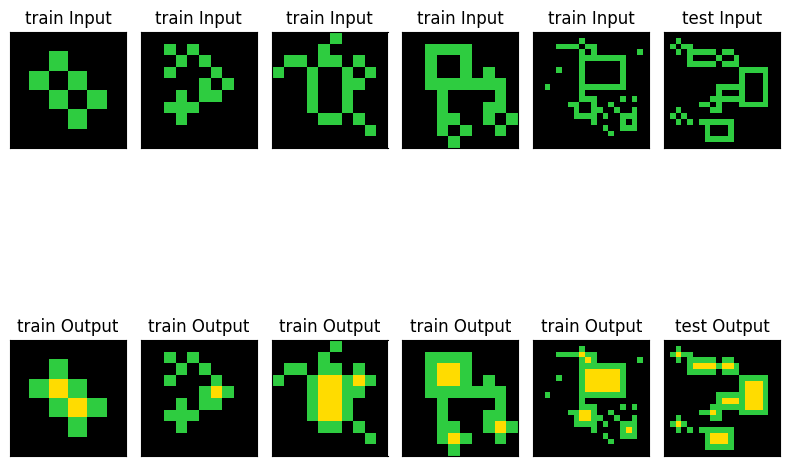

In [7]:
# 可以看的两个任务完全不同的处理方式,这也是该项目所探索的模型的推理和泛化能力
plot_task(task2)

In [8]:
'''
I will be demonstrating how one can use data augmentation and supervised machine learning 
to build a baseline model to solve this problem.
'''

# Extract training and testing data
X_test, X_train, y_train = [], [], []
for file in test_dir:
    with open(os.path.join(test_path, file)) as f:
        task = json.load(f)
    xs_test, xs_train, ys_train = [], [], []
    for pair in task['train']:
        xs_train.append(pair['input'])
        ys_train.append(pair['output'])
    for pair in task['test']:
        xs_test.append(pair['input'])
    X_test.append(xs_test)
    X_train.append(xs_train)
    y_train.append(ys_train)

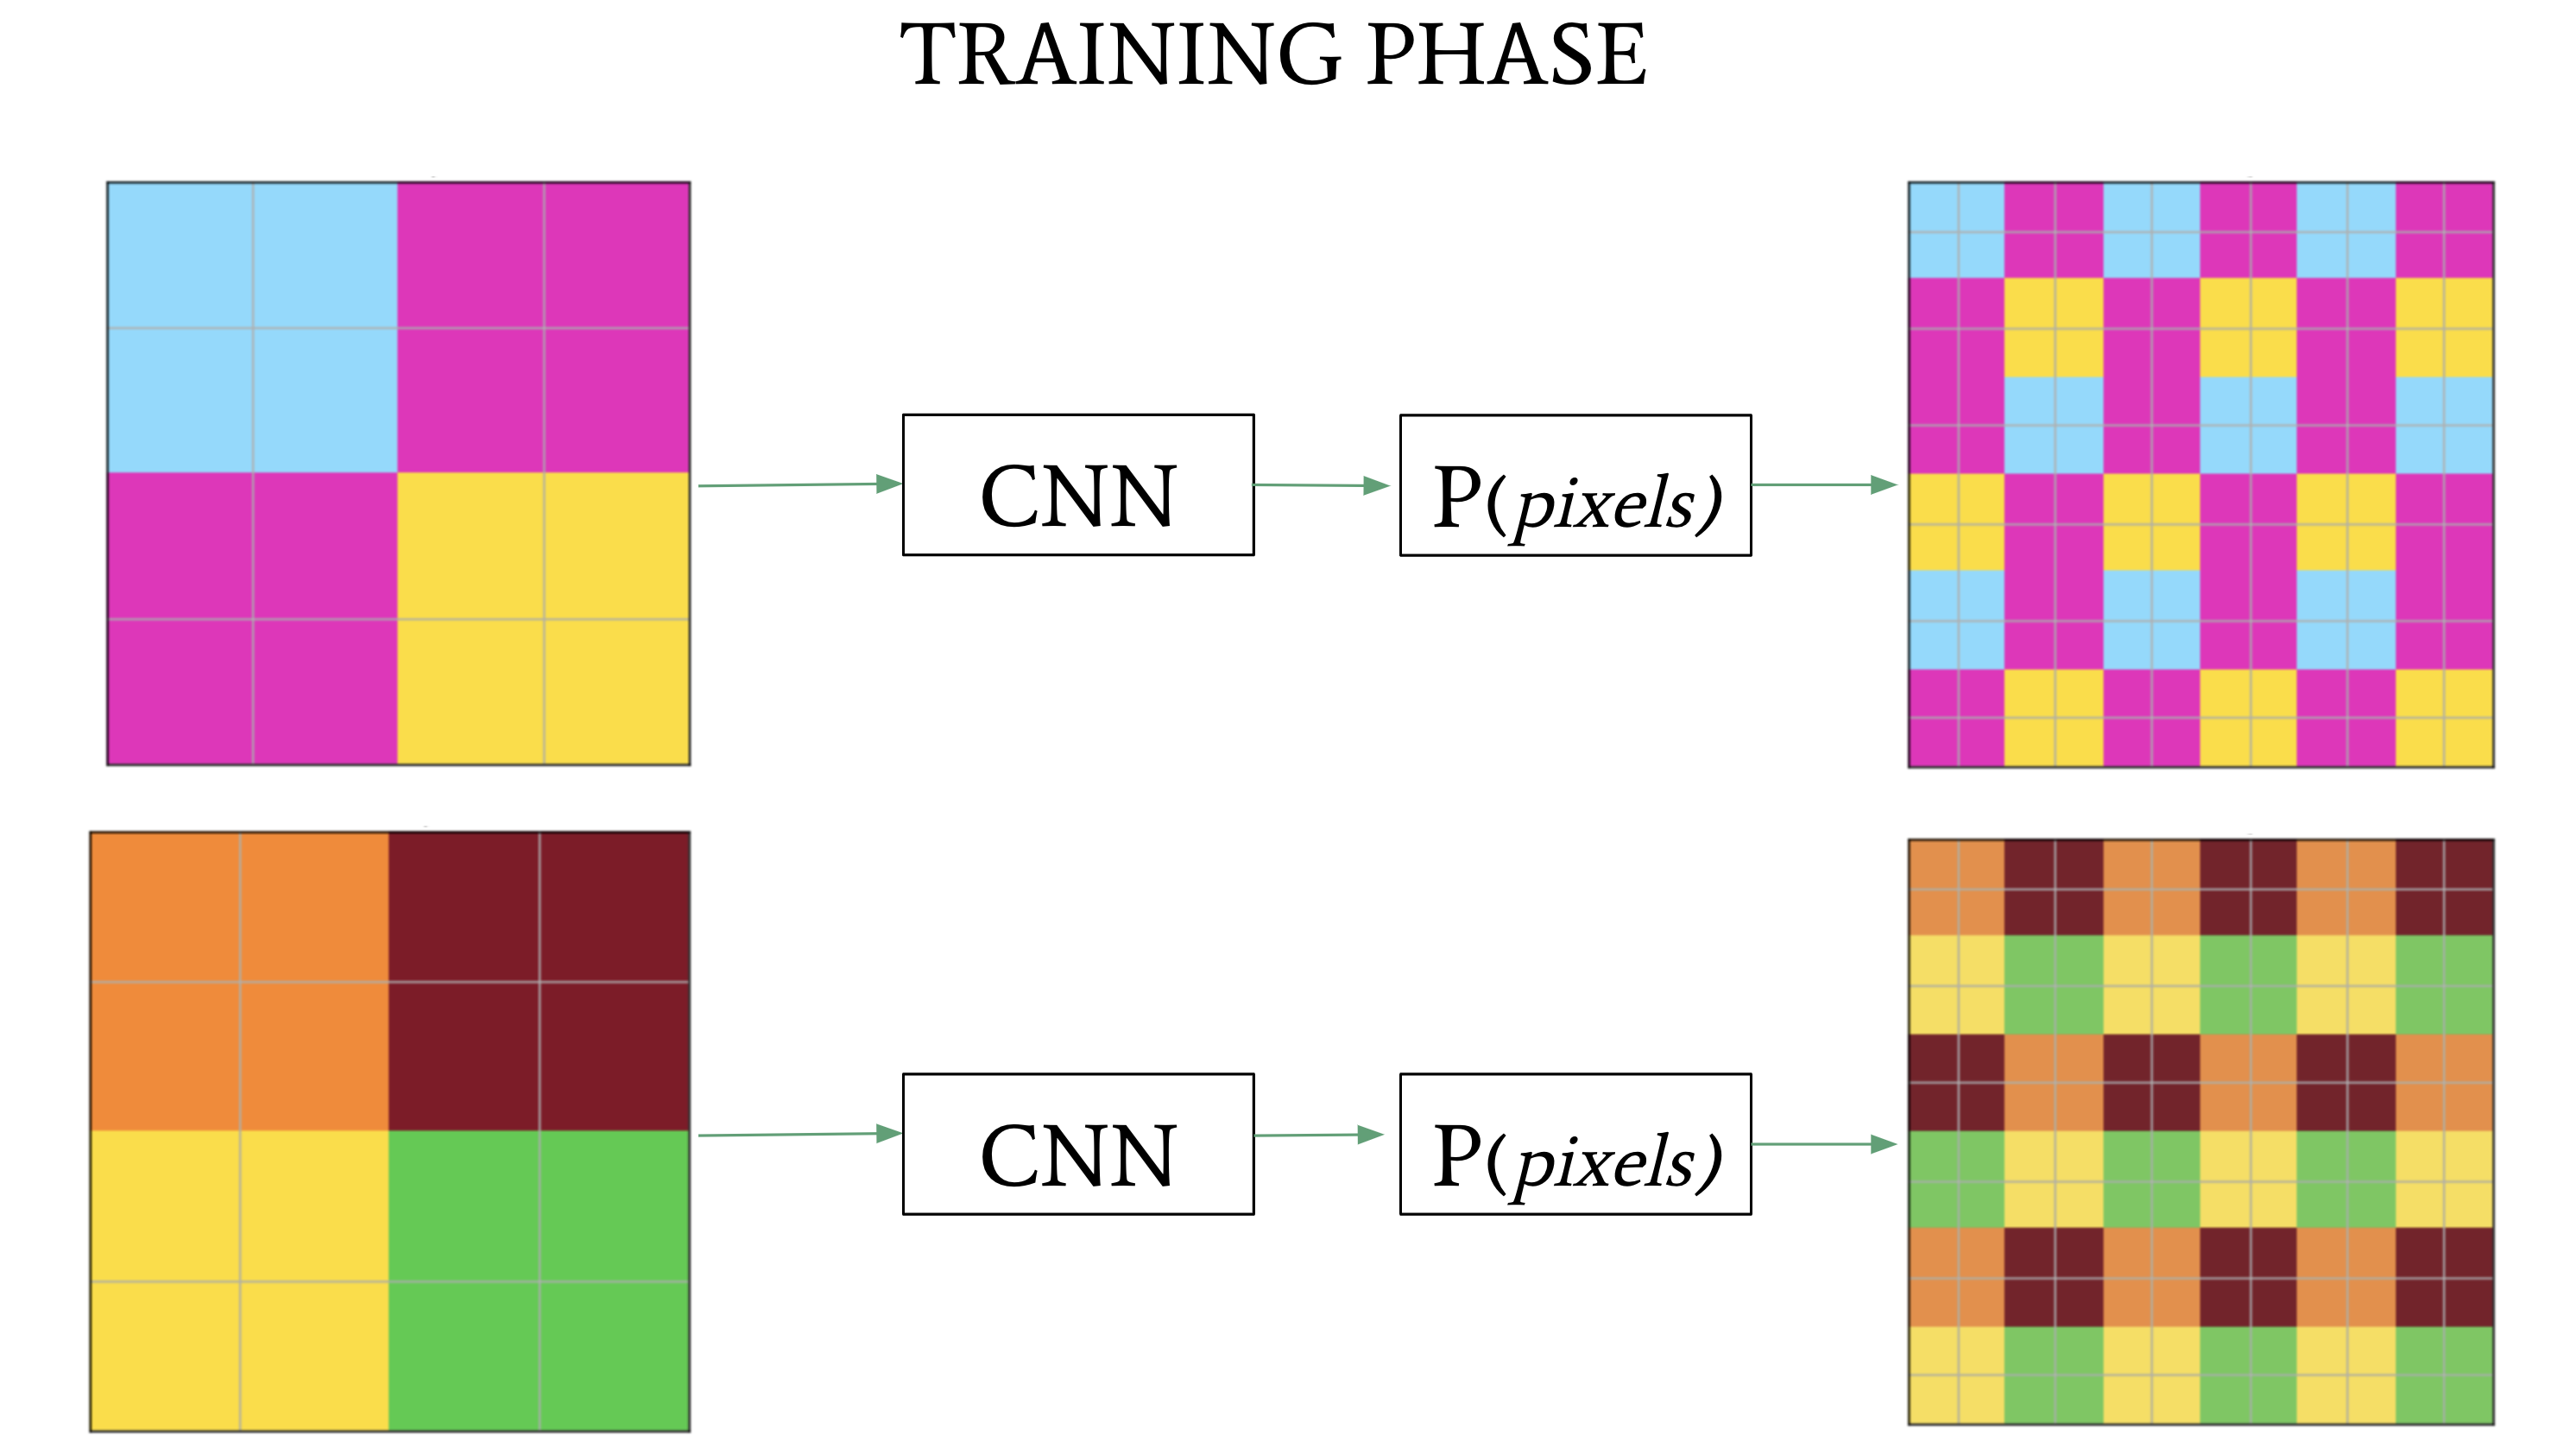

In [9]:
for i in range(10):
    print([np.array(j).shape for j in X_test[i]])
    print([np.array(j).shape for j in X_train[i]])
    print([np.array(j).shape for j in y_train[i]])

[(2, 2)]
[(2, 2), (2, 2)]
[(6, 6), (6, 6)]
[(14, 14)]
[(14, 14), (14, 14), (14, 14), (14, 14), (14, 14)]
[(14, 14), (14, 14), (14, 14), (14, 14), (14, 14)]
[(20, 20)]
[(7, 7), (9, 9), (15, 15), (13, 13)]
[(7, 7), (9, 9), (15, 15), (13, 13)]
[(10, 10)]
[(10, 10), (10, 10), (10, 10)]
[(10, 10), (10, 10), (10, 10)]
[(30, 30)]
[(30, 30), (30, 30), (30, 30)]
[(30, 30), (30, 30), (30, 30)]
[(24, 22)]
[(23, 22), (21, 22), (22, 22)]
[(23, 22), (21, 22), (22, 22)]
[(3, 3)]
[(3, 3), (3, 3), (3, 3)]
[(9, 9), (9, 9), (9, 9)]
[(20, 20)]
[(30, 20), (20, 10)]
[(30, 20), (20, 10)]
[(13, 13)]
[(11, 11), (11, 11), (12, 12)]
[(11, 11), (11, 11), (12, 12)]
[(30, 30)]
[(30, 30), (30, 30), (30, 30), (30, 30)]
[(4, 4), (4, 5), (9, 4), (3, 7)]


Dataset

In [ ]:
# help function

# When training data shape is different, only keep the first item
def get_new_matrix(x, y):
    if len(set([np.array(i).shape for i in x])) > 1 or len(set([np.array(i).shape for i in y])) >1 :
        return [x[0]], [y[0]]
    else:
        return x,y

# Normalize the size of training data 
def repeat(x):
    return np.concatenate([x]*(SIZE//len(x) + 1))[:SIZE]

# Replace the pixels to random color
def replace_values(x, dictionary):
    return np.array([dictionary[j] for i in x for j in i]).reshape(np.array(x).shape)

# Flatten the output and turn to one-hot encoding
def get_outp(x):
    return keras.utils.to_categorical(x.flatten(), num_classes=10).flatten()

In [ ]:
class ARCDataset(Dataset):
    def __init__(self,X, Y):
        self.x = X
        self.y = Y
        self.x, self.y = get_new_matrix(self.x, self.y)
        self.x, self.y = repeat(self.x), repeat(self.y)
    def __len__(self):
        return SIZE
    def __getitem__(self, item):
        x = self.x[item]
        y = self.y[item]
        rep_dic = np.arange(10)
        org_dic = np.arange(10)
        np.random.shuffle(rep_dic)
        dictionary = dict(zip(org_dic, rep_dic))
        # 数据进行转换，数据增强
        x, y = replace_values(x, dictionary), replace_values(y, dictionary)
        outpr = get_outp(y)
        return x, outpr

Define the model

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BasicCNN, self).__init__()
        self.conv_in = 3
        self.conv_out1 = 50
        self.conv_out2 = 100
        if input_dim[0] or input_dim[1] < 5:
            KERNEL_SIZE = 1
        else:
            KERNEL_SIZE = 3
        self.conv1 = nn.Conv2d(self.conv_in, self.conv_out1, kernel_size=KERNEL_SIZE)
        self.conv2 = nn.Conv2d(self.conv_out1, self.conv_out2, kernel_size=KERNEL_SIZE)
        self.dense1 = nn.Linear(self.conv_out2, output_dim[0] * output_dim[1] * 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        '''
        [batch, imgx, imgy] => [batch, channel, imgx, imgy]
        '''
        x = torch.cat([x.unsqueeze(0)]*3)  # [3, batch, imgx, imgy]
        x = x.permute((1,0,2,3)).float()
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(conv1))  # [batch, channel, imgx, imgy]
        pooling, _ = torch.max(conv2, dim=-1) # [batch, channel, imgx]
        pooling, _ = torch.max(pooling, dim=-1)  # [batch ,channel]
        result = self.dense1(pooling)  # [batch, output_dim[0] * output_dim[1] * 10]
        result = torch.softmax(result.reshape(result.shape[0],-1,10), dim=-1).reshape(result.shape[0], -1)
        return result

In [ ]:
import cv2
def resize(x, input_dim, test_dim):
    if input_dim == test_dim:
        return x
    else:
        return cv2.resize(np.float32(x), input_dim, interpolation=cv2.INTER_AREA)

In [ ]:
EPOCHS = 50
idx = 0
start = time.time()
test_predictions = []

for x_, y_ in zip(X_train, y_train):
    dataset = ARCDataset(x_, y_)
    data_loader = DataLoader(dataset, batch_size=128)
    input_dim = np.array(x_[0]).shape
    output_dim = np.array(y_[0]).shape
    network = BasicCNN(input_dim, output_dim).cuda()
    optimizer = torch.optim.Adam(network.parameters(),lr=0.01)
    for epoch in range(EPOCHS):
        for i in data_loader:
            train_x, train_y = i
            logists = network(train_x.cuda())
            loss = nn.MSELoss()(train_y.cuda(), logists)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # print(epoch, loss.item())

    end = time.time()        
    print("Train loss: " + str(np.round(train_loss.item(), 3)) + "   " +\
          "Total time: " + str(np.round(end - start, 1)) + " s" + "\n")
    
    for test_ in X_test[idx]:
        test_ = resize(test_, input_dim, np.array(test_).shape)
        # input:[batch, input_dim] # output:[batch, seq]
        logist_test = network(torch.tensor(test_).unsqueeze(0)).detach().numpy()
        logist_test = np.argmax(logist_test.reshape(-1, 10), axis=-1).reshape(output_dim)
        test_predictions.append(logist_test)
    idx += 1

In [ ]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

results = []
for i in test_predictions:
    results.append(flattener([list(j) for j in i]))
print(results)